# Family visit research for Chinese students

 Most of Chinese students during their graduation ceremony are facing a problem -- Their family (mostly parents) would like to attend the ceremony, but they usually face some incapable problems:<br/> 
1) Complex international travel related tasks in a foreign language <br/>
2) Housing <br/>
3) Tour route selection <br/>
4) Transportation <br/>
5) Students love to give their parents a comfortable travel experience, but they are inexperienced or too busy for it. <br/>
Based on that, I developed a research survey to understand their need and potential in this market.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
import numpy as np

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

## Read and clean data

The purpose of this project is to identity all students that has a need for family visit. After selection, all data selected from rawdata show 'yes' in Q1 (Do you have need for family visit), then delete column Q1

Each column representing:<br/>
#### Q2: Gender - female as 0, male as 1 (int)
#### Q3: Education: Undergrad; Grad (str)
#### Q4: Age Range: 18-25; 26-33; 34 and above (str)
#### Q5: Job Status: already have a job; found a job but not start yet; currently looking for jobs (str)
#### Q6: Daily Free Hours (int)
#### Q7: Travel interval: 1 to 2 weeks; 2 weeks to 1 month; more than 1 month (str)
#### Q8: Travel Budget (int)
#### Q9: Purpose: travel; accompany (int)
#### Q10: Need for visa help from 1 to 7 (int)
#### Q11: Need for daily transpotation from 1 to 7 (int)
#### Q12: Need for housing from 1 to 7 (int)
#### Q13: Need for international insurance from 1 to 7 (int)
#### Q14: Need for tour arrangement from 1 to 7 (int)

In [2]:
data = pd.read_csv('rdata.csv',encoding="ISO-8859-1")
data = data.drop(columns ='q1')
print('This dataset contains',data.shape[0],'rows of data and',data.shape[1],'columns')
data.head(10)

This dataset contains 99 rows of data and 15 columns


,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,do you prefer package service for parent visit?\r
0,0,graduate,26-33,currently looking for jobs,3,2 weeks to 1 month,7000,travel,1,4,6,1,6,None,0
1,1,graduate,26-33,found a job but not start yet,18,more than 1 month,10000,accompany,2,6,1,4,6,None,0
2,1,graduate,18-25,already have a job,16,1 to 2 weeks,3000,travel,7,7,3,3,7,NaN,0
3,1,graduate,18-25,currently looking for jobs,20,2 weeks to 1 month,5000,travel,7,7,7,4,7,transpotation,1
4,1,graduate,18-25,already have a job,2,1 to 2 weeks,5000,accompany,7,7,6,4,7,translation guide,0
5,0,graduate,26-33,currently looking for jobs,5,1 to 2 weeks,10000,travel,1,5,7,1,7,no,1
6,0,graduate,18-25,found a job but not start yet,10,1 to 2 weeks,1000,accompany,5,5,5,5,5,None,0
7,1,graduate,26-33,currently looking for jobs,14,more than 1 month,10000,accompany,6,3,1,1,5,None,0
8,1,graduate,18-25,currently looking for jobs,20,1 to 2 weeks,10000,travel,2,2,5,5,2,None,0
9,0,graduate,18-25,currently looking for jobs,10,2 weeks to 1 month,10000,accompany,4,4,4,4,4,None,0


If Q8 (travel budget) value is not None, convert value to integer type (for further calculation of average budget)

In [3]:
def str_to_int(df):
    if df['q8']!='None':
        return int(df['q8'])
    else:
        return 'None'
data['q8'] = data.apply(lambda r: str_to_int(r),axis = 1)

## Fill missing value in q8

For values under Q8 that is None, these missing values are assigned with average budget of others

In [4]:
def assign_na(df):
    ave_budget = int(data.loc[data['q8']!='None']['q8'].mean())
    if df['q8'] == 'None':
        return ave_budget
    else:
        return df['q8']
data['q8'] = data.apply(lambda r: assign_na(r),axis=1)

## Dummy coding catagorical variables : Q3, Q4, Q5, Q7, Q9

Q3,Q4,Q5,Q7,Q9 is categorical variable, representing: Education, Age, Job status, Length of planing visit, Purpose of visit

They are actually ordinal categorical variables, with internal order and logic inside, so seperately dummy coding it with ascending number

In [5]:
data['q3'] = data['q3'].apply(lambda x:0 if x == 'undergrad' else 1 )
data['q4'] = data['q4'].apply(lambda x:0 if x == '18-25' else( 1 if x == '26-33' else 2))

data['q5'] = data['q5'].apply(lambda x:0 if x == 'currently looking for jobs'else (1 if x == 'found a job but not start yet' else 2))

data['q7'] = data['q7'].apply(lambda x:1 if x == '2 weeks to 1 month' else (0 if x == '1 to 2 weeks' else 2))
data['q9'] = data['q9'].apply(lambda x:0 if x == 'travel' else 1 )
data.head(10)

,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,do you prefer package service for parent visit?\r
0,0,1,1,0,3,1,7000,0,1,4,6,1,6,None,0
1,1,1,1,1,18,2,10000,1,2,6,1,4,6,None,0
2,1,1,0,2,16,0,3000,0,7,7,3,3,7,NaN,0
3,1,1,0,0,20,1,5000,0,7,7,7,4,7,transpotation,1
4,1,1,0,2,2,0,5000,1,7,7,6,4,7,translation guide,0
5,0,1,1,0,5,0,10000,0,1,5,7,1,7,no,1
6,0,1,0,1,10,0,1000,1,5,5,5,5,5,None,0
7,1,1,1,0,14,2,10000,1,6,3,1,1,5,None,0
8,1,1,0,0,20,0,10000,0,2,2,5,5,2,None,0
9,0,1,0,0,10,1,10000,1,4,4,4,4,4,None,0


## Standardlize variables

Before clustering, we can see Q8 and Q6 may have larger standard deviation or range then other, so need to srandardlize them first

In [6]:
data = data.drop(columns = ['q15'])
data2 = data
t = preprocessing.StandardScaler().fit(data2)
data2 = t.transform(data2)

## Hierarchal clustering (ward method)

For hierarchal clustering, after trying various method for distance calculation, Ward method shows good ability to seperate groups

In [7]:
Z = linkage(data2,'ward')
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(data2))

## Dendrogram 

From the dendrogram we can see: setting distance threshold to 15, there are clearly three clusters

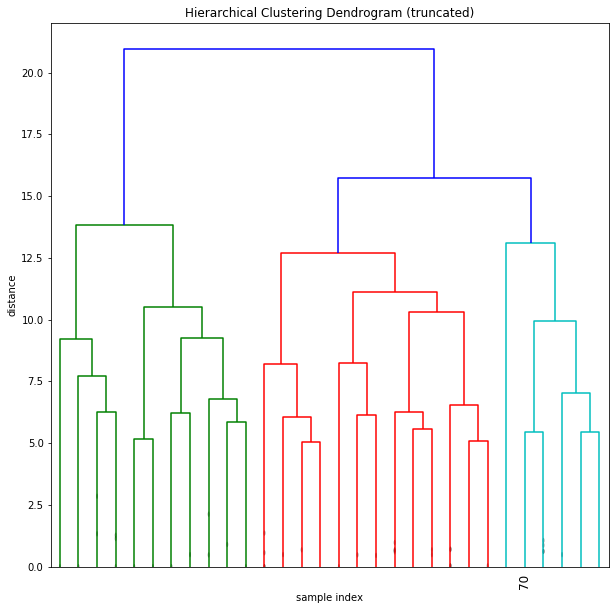

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=30, show_leaf_counts=False, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()

In [9]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

## Set distance threshold to 15, got 3 clusters

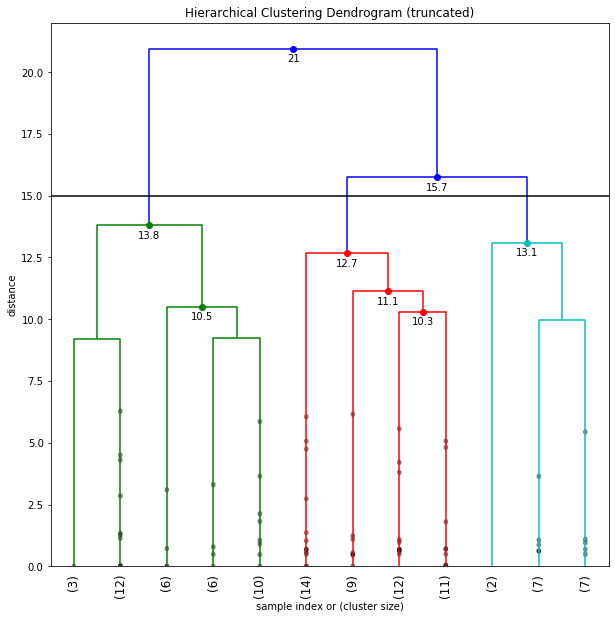

In [10]:
plt.figure(figsize = (10,10))
max_d = 15
fancy_dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=10, max_d=max_d)
plt.show()

In [11]:
from scipy.cluster.hierarchy import fcluster
max_d = 15
clusters = fcluster(Z, max_d, criterion='distance')

After assign labels back to data, we can see the attributes' mean of each clusters

In [12]:
data['cluster'] = clusters
groups = data.groupby('cluster').mean()
print(groups)

               q2        q3        q4        q5         q6        q7  \
cluster                                                                
1        0.810811  0.648649  0.243243  0.567568   9.783784  1.054054   
2        0.478261  0.956522  0.413043  0.456522   6.847826  0.478261   
3        0.875000  0.562500  0.375000  0.000000  16.500000  0.812500   

                   q8        q9       q10       q11       q12       q13  \
cluster                                                                   
1        16705.945946  0.459459  3.216216  3.027027  2.810811  2.675676   
2         9251.304348  0.543478  5.021739  5.891304  5.391304  3.695652   
3        44785.000000  0.312500  7.125000  6.875000  6.750000  5.875000   

              q14  do you prefer package service for parent visit?\r  
cluster                                                               
1        3.405405                                           0.000000  
2        6.021739                                 

### Based on meaning of each variable, we got group portrait of each clusters:###
<br>
Cluster-1: mostly undergrad students, age from 18-25, most of them already got a job with less free hours. They mostly have high travel budget, both have low needs of all kinds of services.  
<br>
   Cluster-2: most graduate students, age around 25, got a job but not enrolled. they have time, with lower budget. They show common need for all services.
<br>
   Cluster-3: male, graduate students, age around 25, still lookiing for jobs. They have more free time and longer travel interval, high budget for travel purpose. they  have high need for all services.

### Radar chart for user portrait

we can also visualize their characteristics in a Radar chart for better understanding

we combine all needs questions from Q10 to Q14 into a variable "service" to make it clearer

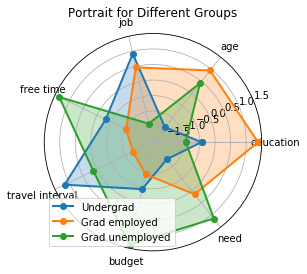

In [13]:
from math import pi
groups.head(10)
groups['service'] = (groups['q10']+groups['q11']+groups['q12']+groups['q13']+groups['q14'])/5
groups = groups.drop(columns = ['q2','q10','q11','q12','q13','q14'])
groups = groups.drop(columns = 'do you prefer package service for parent visit?\r')
catagory = groups.columns
groups = groups.drop(columns = 'q9')
t = preprocessing.StandardScaler().fit(groups)
groups = t.transform(groups)
groups = pd.DataFrame(groups)
groups.columns = ['education','age','job','free time','travel interval','budget','need']
cate = list(groups.columns)
N = len(cate)
values = groups.values.flatten().tolist()
values1 = values[:7]
values2 = values[7:14]
values3 = values[14:]

angles = np.linspace(0,2*pi,N,endpoint = False)
values1=np.concatenate((values1,[values1[0]]))
values2=np.concatenate((values2,[values2[0]]))
values3=np.concatenate((values3,[values3[0]]))
angles=np.concatenate((angles,[angles[0]]))

fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values1, 'o-', linewidth=2, label = 'Undergrad')
ax.fill(angles, values1, alpha=0.25)
ax.plot(angles, values2, 'o-', linewidth=2, label = 'Grad employed')
ax.fill(angles, values2, alpha=0.25)
ax.plot(angles, values3, 'o-', linewidth=2, label = 'Grad unemployed')
ax.fill(angles, values3, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, cate)
ax.set_ylim(-2,1.5)
plt.title('Portrait for Different Groups')

ax.grid(True)
plt.legend(loc = 'lower left')
plt.show()

### From above we can see that:###

Cluster 1 (shorten for Undergrad): <br/>
    They are younger Chinese,they might not in charge of arrangement of their parents travel plan so they don't need to pay attention of any of these services or calculating budget. <br/>

Cluster 2 (shorten for Grad employed): <br/>They mostly just graduate from master degree. They may already in a job or had an offer, means they are more rational, actionale and maybe good at planing. Their parents have a shorter travel interval, it makes them easier to handle the travel arrangment, so they shown a ambiguous attitude towards services. 

Cluster 3: (shorten for Grad unemployed): <br/>They mostly just graduated from master degree but still in job hunting, though they have more free time, looking for jobs may consume most of their time. They may in a dilemma or stressed, so they have higher budget and need for the services.  

#### Conclusion: Cluster 3 could be a good potential group for the services assistance 